In [25]:
#Wineデータの取得
import pandas as pd

df_wine = pd.read_csv('./python-machine-learning-book-2nd-edition-master/code/ch07/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label']!=1]
y = df_wine['Class label'].values
#X = df_wine.iloc[:,1:]
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values


In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min() -1, X[:,0].max() +1 
    x2_min, x2_max = X[:,1].min() -1, X[:,1].max() +1 
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=colors[idx], label=cl, edgecolor='black')
        
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c='', edgecolor='black', alpha=1.0, linewidth=1, marker='o', s=100, label='test set')

Bagging train/test accuracies 1.000/0.833


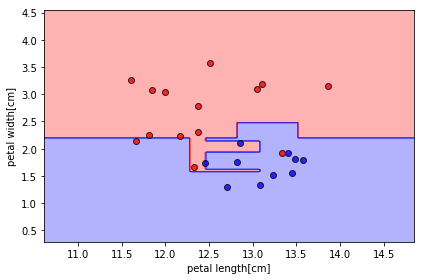

In [60]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
tree.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

plot_decision_regions(X_test, y_test, classifier=tree, test_idx=None)

plt.xlabel('petal length[cm]')
plt.ylabel('petal width[cm]')

plt.tight_layout()
plt.show()

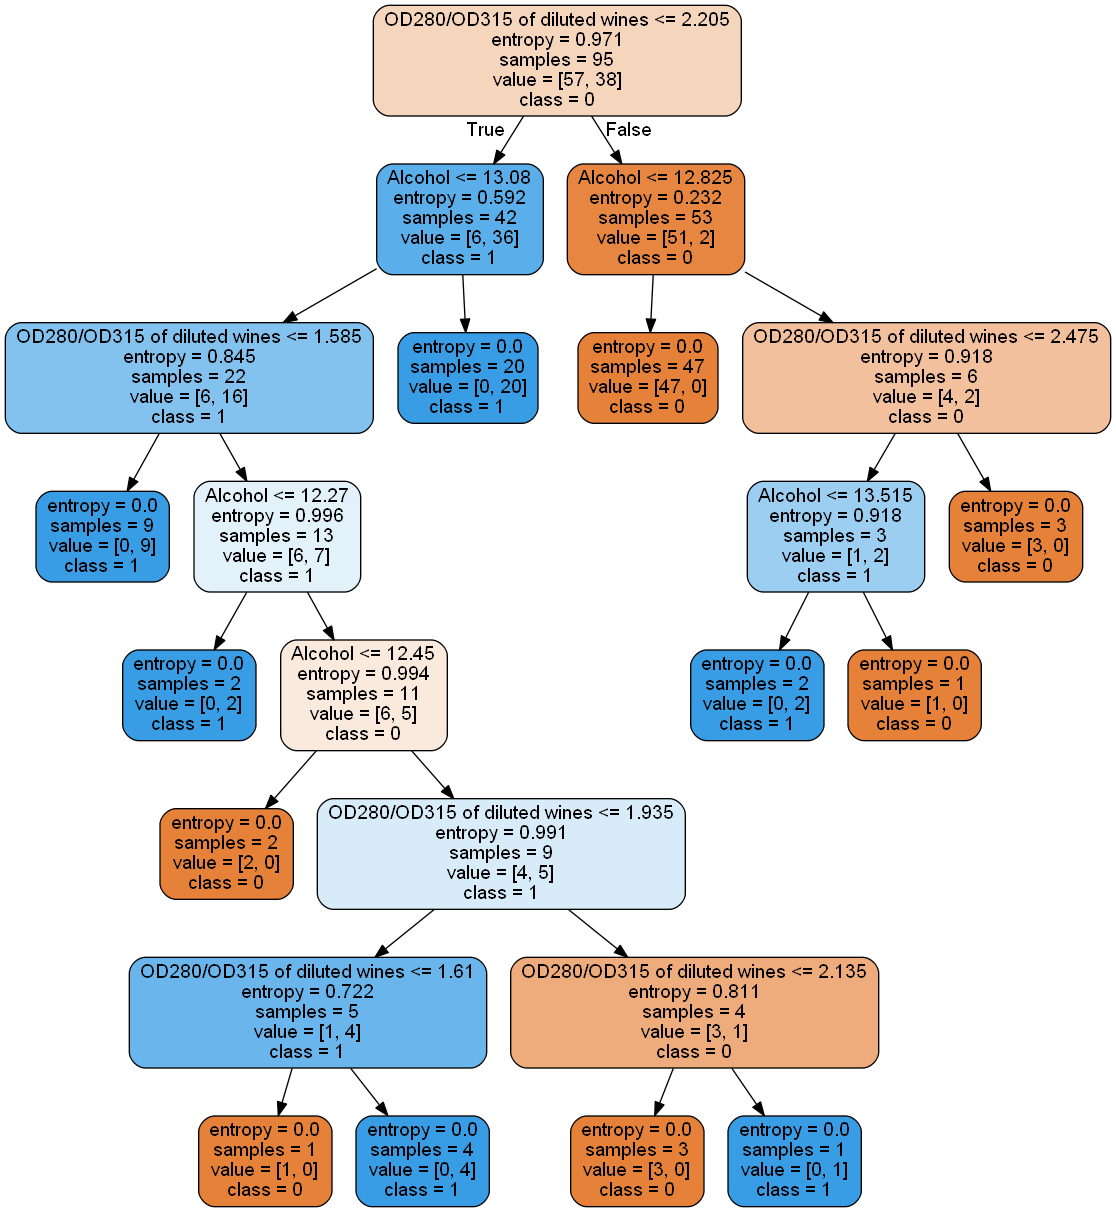

In [48]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image #jupyter上での表示

dot_data = export_graphviz(tree, filled=True, rounded=True,
                           class_names=['0', '1'],
                           feature_names=['Alcohol','OD280/OD315 of diluted wines'],
                           out_file=None)

graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
Image(graph.create_png())

In [62]:
#bagginでのfit
from sklearn.ensemble import BaggingClassifier

bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                        bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


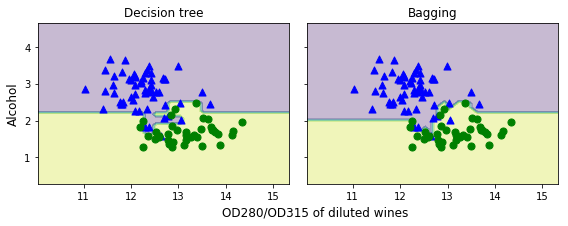

In [66]:
#treeとbaggingの比較

x_min = X_train[:,0].min()-1
x_max = X_train[:,0].max()+1
y_min = X_train[:,1].min()-1
y_max = X_train[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(8,3))

for idx, clf, tt in zip([0,1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol',fontsize=12)
plt.text(10.2, -0.5, s='OD280/OD315 of diluted wines', ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()